# Make sure to select hand segmentation as kernel

In [42]:
import pycocotools as O
print(O.__file__)

/scratch/ndillenb/.conda/envs/hands/lib/python3.7/site-packages/pycocotools/__init__.py


/scratch/ndillenb/notebooks/Hand-Segmentation


# Setup Dataset Class

In [1]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages1"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks_seg"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages1", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks_seg", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        #print(self.masks[idx])
        #print(num_objs)
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if ((xmin != xmax) and (ymin != ymax)):
                boxes.append([xmin, ymin, xmax, ymax])
            #print(boxes[i])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        #print(img_path)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
print(torchvision.models.detection.faster_rcnn.__file__)
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/scratch/ndillenb/.conda/envs/hand_segmentation/lib/python3.10/site-packages/torchvision/models/detection/faster_rcnn.py


/scratch/ndillenb/.conda/envs/hand_segmentation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/ndillenb/.conda/envs/hand_segmentation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

/scratch/ndillenb/.conda/envs/hand_segmentation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
import transforms  as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('Hands_dataset', get_transform(train=True))
dataset_test = PennFudanDataset('Hands_dataset', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=25,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=25,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.01)



/scratch/ndillenb/.conda/envs/hand_segmentation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train model

In [7]:
# let's train it for 1000 epochs
num_epochs = 4
evalutaltion = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    print('evaluate')
    # evaluate on the test dataset
    evalutaltion.append(evaluate(model, data_loader_test, device=device))
print("That's it!")

Epoch: [0]  [ 0/53]  eta: 0:12:07  lr: 0.000101  loss: 3.6735 (3.6735)  loss_classifier: 0.5674 (0.5674)  loss_box_reg: 0.1033 (0.1033)  loss_mask: 2.8384 (2.8384)  loss_objectness: 0.1474 (0.1474)  loss_rpn_box_reg: 0.0171 (0.0171)  time: 13.7223  data: 1.0145  max mem: 4172
Epoch: [0]  [10/53]  eta: 0:01:17  lr: 0.001062  loss: 2.1287 (2.4175)  loss_classifier: 0.3076 (0.3749)  loss_box_reg: 0.1714 (0.1674)  loss_mask: 1.4961 (1.7865)  loss_objectness: 0.0489 (0.0739)  loss_rpn_box_reg: 0.0162 (0.0149)  time: 1.8071  data: 0.1099  max mem: 4350
Epoch: [0]  [20/53]  eta: 0:00:40  lr: 0.002022  loss: 1.1606 (1.7677)  loss_classifier: 0.1881 (0.2638)  loss_box_reg: 0.1586 (0.1603)  loss_mask: 0.8075 (1.2760)  loss_objectness: 0.0277 (0.0550)  loss_rpn_box_reg: 0.0116 (0.0126)  time: 0.6134  data: 0.0107  max mem: 4350
Epoch: [0]  [30/53]  eta: 0:00:23  lr: 0.002983  loss: 1.0356 (1.7070)  loss_classifier: 0.1271 (0.2237)  loss_box_reg: 0.1335 (0.1478)  loss_mask: 0.6515 (1.0755)  loss_o

Epoch: [2]  [ 0/53]  eta: 0:01:13  lr: 0.005000  loss: 0.8483 (0.8483)  loss_classifier: 0.1401 (0.1401)  loss_box_reg: 0.1416 (0.1416)  loss_mask: 0.5328 (0.5328)  loss_objectness: 0.0298 (0.0298)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.3817  data: 0.8411  max mem: 4350
Epoch: [2]  [10/53]  eta: 0:00:30  lr: 0.005000  loss: 0.8927 (1.1439)  loss_classifier: 0.1330 (0.1310)  loss_box_reg: 0.1588 (0.1607)  loss_mask: 0.5342 (0.5728)  loss_objectness: 0.0269 (0.0763)  loss_rpn_box_reg: 0.0115 (0.2031)  time: 0.7065  data: 0.0994  max mem: 4350
Epoch: [2]  [20/53]  eta: 0:00:21  lr: 0.005000  loss: 0.8667 (0.9914)  loss_classifier: 0.1081 (0.1157)  loss_box_reg: 0.1324 (0.1457)  loss_mask: 0.5823 (0.5588)  loss_objectness: 0.0297 (0.0601)  loss_rpn_box_reg: 0.0085 (0.1110)  time: 0.6254  data: 0.0134  max mem: 4350
Epoch: [2]  [30/53]  eta: 0:00:15  lr: 0.005000  loss: 0.8519 (0.9460)  loss_classifier: 0.1000 (0.1160)  loss_box_reg: 0.1334 (0.1530)  loss_mask: 0.5339 (0.5485)  loss_ob

# Show metrics

In [8]:
from io import StringIO
import sys
old_stdout = sys.stdout
output = StringIO()
sys.stdout = output
printed_text = []
for element in evalutaltion:
    element.summarize()
    printed_text.append(output.getvalue())
    output = StringIO()
    sys.stdout = output

# Restore stdout to the console
sys.stdout = old_stdout

# Print the captured text
print(printed_text[-1])

NameError: name 'evalutaltion' is not defined

In [170]:
F1_all = []
AR_all = []
AP_all = []
for element in printed_text:
    i = 0
    AP = []
    AR = []
    F1 = []
    for element_txt in element.splitlines():
        if (i > 13) and (i < 20):
            #print(element_txt[74:])
            AP.append(float(element_txt[74:]))
        if (i > 13) and (i > 19) and (i<26):
            #print(element_txt[74:])
            AR.append(float(element_txt[74:]))
        i=i+1
    for i in range(len(AP)):
        try: 
            F1.append(2*AP[i]*AR[i]/(AP[i]+AR[i]))
        except ZeroDivisionError:
            F1.append('nan')
    print(F1)
    F1_all.append(F1)
    AR_all.append(AR)
    AP_all.append(AP)

['nan', 'nan', 'nan', 'nan', 'nan', 'nan']
['nan', 'nan', 'nan', 'nan', 'nan', 'nan']
[0.14098591549295772, 0.2653874538745387, 0.1463988764044944, 'nan', 0.10453968253968252, 0.246293542074364]
[0.1275, 0.2252806652806653, 0.11508771929824561, 'nan', 0.08569756097560975, 0.20721882352941176]
[0.11959166666666668, 0.21032967032967034, 0.07996444444444444, 'nan', 0.07873255813953489, 0.18581432360742706]
[0.124968, 0.19655172413793104, 0.09797379912663755, 'nan', 0.075, 0.1773221288515406]
[0.124968, 0.19655172413793104, 0.09797379912663755, 'nan', 0.075, 0.1773221288515406]
[0.124968, 0.19655172413793104, 0.09797379912663755, 'nan', 0.075, 0.1773221288515406]
[0.12448192771084338, 0.19655172413793104, 0.09797379912663755, 'nan', 0.075, 0.1773221288515406]
[0.12448192771084338, 0.19655172413793104, 0.09797379912663755, 'nan', 0.075, 0.1773221288515406]


## Plot F1

IoU=0.50:0.95 | area=   all


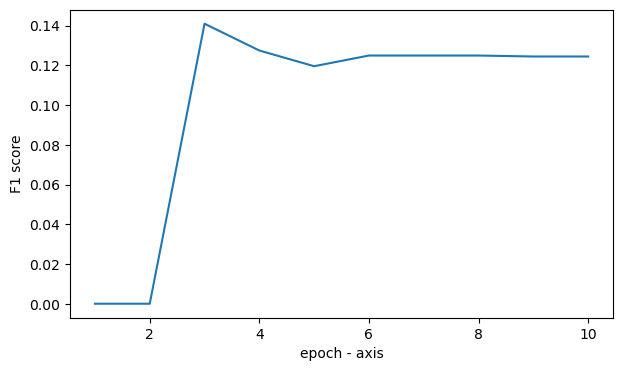

IoU=0.50      | area=   all


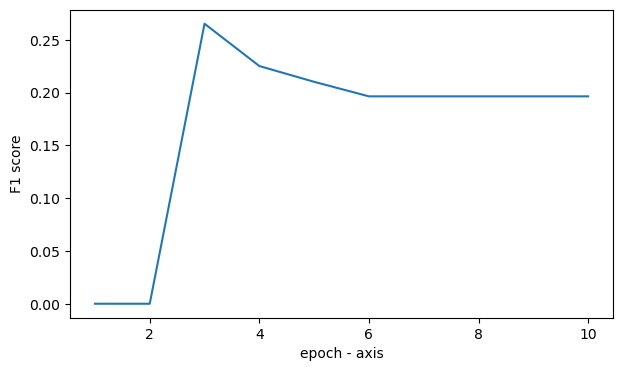

IoU=0.75      | area=   all


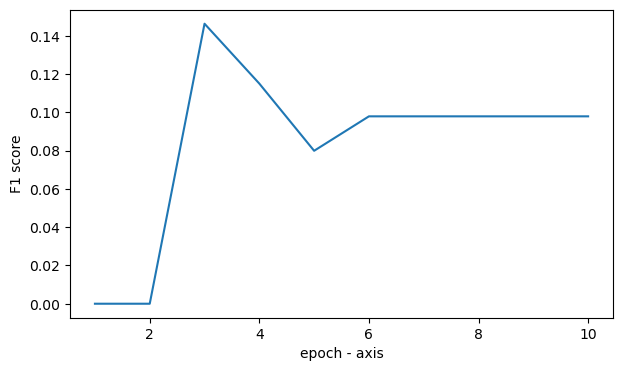

IoU=0.50:0.95 | area= small


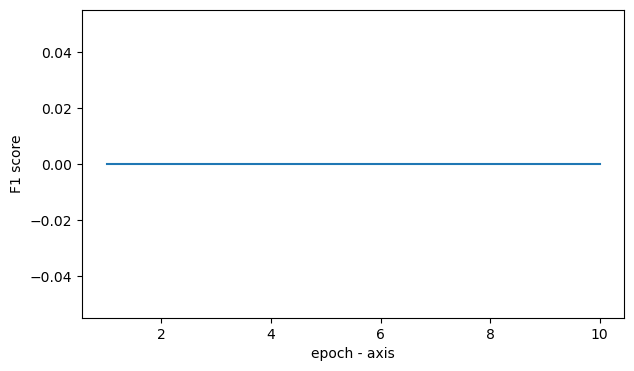

IoU=0.50:0.95 | area=medium


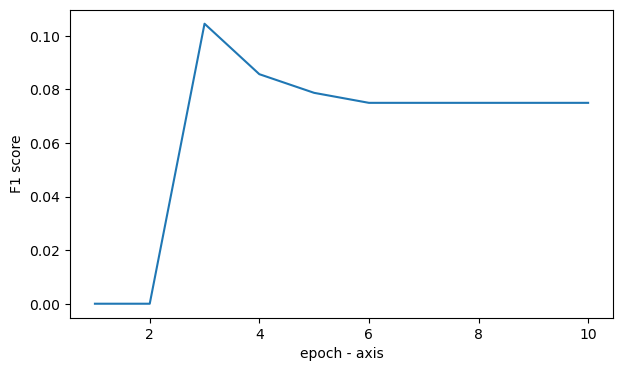

IoU=0.50:0.95 | area= large


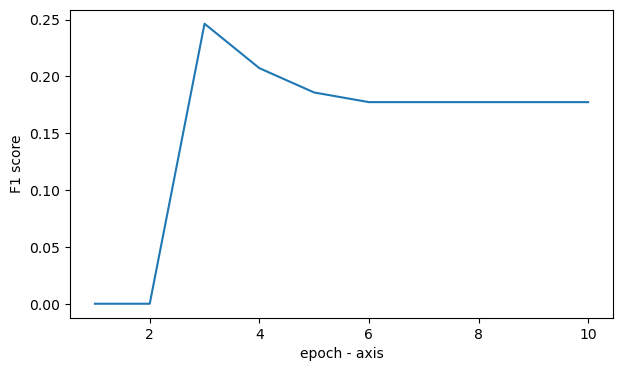

In [168]:
import matplotlib.pyplot as plt
txt = ['IoU=0.50:0.95 | area=   all','IoU=0.50      | area=   all', 'IoU=0.75      | area=   all','IoU=0.50:0.95 | area= small','IoU=0.50:0.95 | area=medium','IoU=0.50:0.95 | area= large']
x = [i for i in range(1, num_epochs+1)]
plt.rcParams['figure.figsize'] = [7, 4]
for i in range(len(F1_all[0])):
        #print(F1_all[0][0])
        y = []
        for j in range(len(F1_all)):
            if F1_all[j][i]=='nan':
                y.append(0)
            else:
                y.append(F1_all[j][i])
        print(txt[i])
        plt.xlabel('epoch - axis')
        plt.ylabel('F1 score')
        plt.plot(x,y)
        plt.show()

## Plot AR-AP

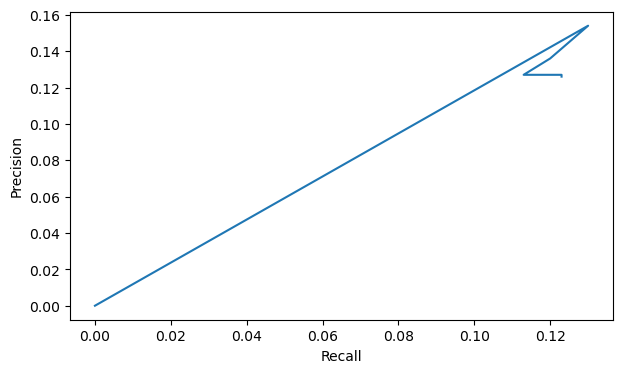

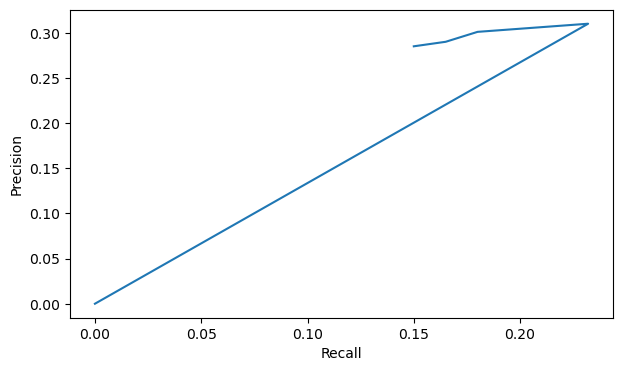

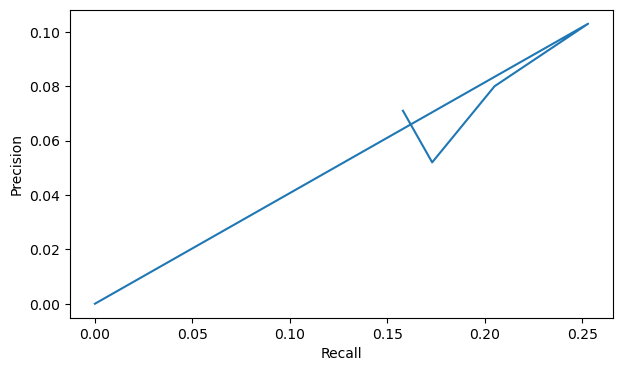

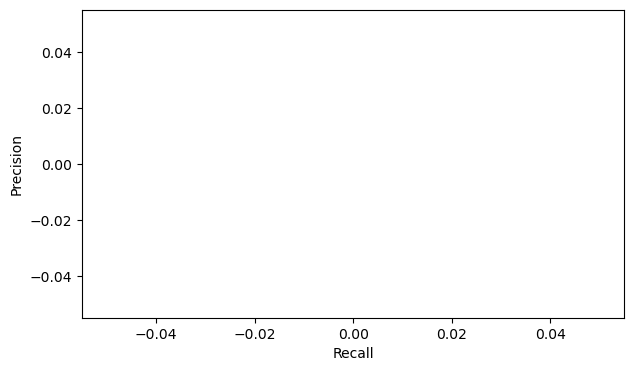

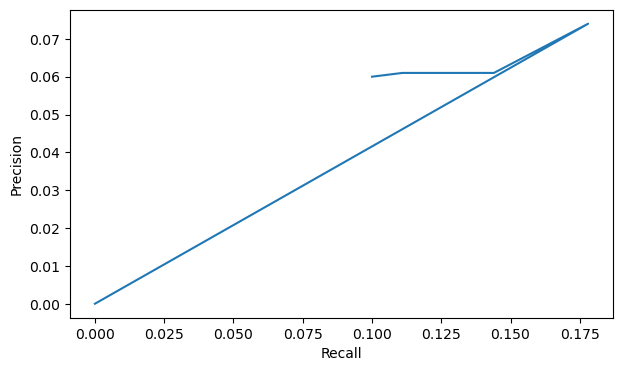

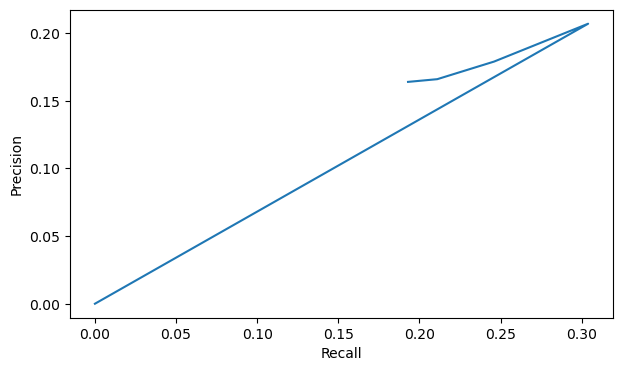

In [181]:
for i in range(len(AR_all[0])):
    x = []
    y = []
    for j in range(len(AR_all)):
        x.append(AR_all[j][i])
        y.append(AP_all[j][i])
    #print(x)
    #print(y)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(x,y)
    plt.show()

# Save model

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
# Additional information

torch.save(model, '/scratch/ndillenb/trained_model_saved/4epoch_25_03_2023.pt')

# Load model

In [9]:
model = torch.load('/scratch/ndillenb/trained_model_saved/10epoch_21_03_2023.pt')

# Show results

In [88]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index

In [89]:
from torchvision import transforms as torchtrans
from matplotlib import pyplot as plt
import matplotlib.patches as patches
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')


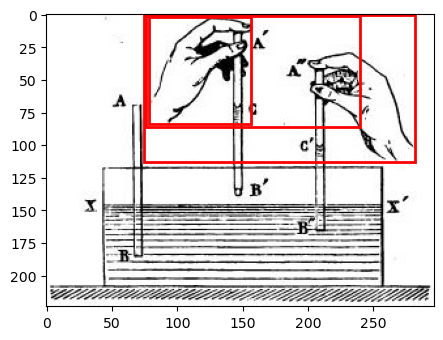

In [117]:
# pick one image from the test set
import random
#for i in range(10):
rnd = random.randrange(1,len(dataset_test))
img, target = dataset_test[rnd]
# put the model in evaluation mode
model.eval()
with torch.no_grad(): #Turn off gradient computation
    predictions = model([img.to(device)])[0]
print((predictions['masks'][0]))
#print(predictions)
#print(target)
#print('predicted #boxes: ', len(prediction['labels']))
#print('real #boxes: ', len(target['labels']))
plot_img_bbox(torch_to_pil(img), target)
plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (1,) and torch.Size([1, 224, 297])

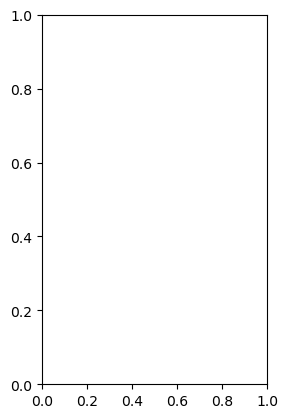

In [119]:
# magic line only if you use Jupyter
%matplotlib inline
from matplotlib import pyplot
...
# assuming mask is batch x h x w and we want the first
#pyplot.subplot(1, 2, 1) # have two plots in 1 row two columns, first plot
# assuming im is batch x channel x h x w and channel is RGB
#pyplot.plot(im[0].detach().cpu().permute(1, 2, 0))
pyplot.subplot(1, 2, 2) # second plot
pyplot.plot(predictions['masks'][0].detach().cpu())

# Plot view

In [25]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')


def get_prediction(img_path, confidence):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img).to(device)
  pred = model([img])
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  #print(np.max(pred_score))
  try:
        pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  except IndexError:
    pred_t = [pred_score.index(x) for x in pred_score if x>=np.max(pred_score)][-1]

  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class, pred_score

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=2):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls, pred_score = get_prediction(img_path, confidence)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # print(len(boxes))
  for i in range(len(boxes)):
    cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])), color=(255, 0, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i]+": "+str(round(pred_score[i],3)), (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)
  plt.figure(figsize=(6,6))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  return pred_score, boxes

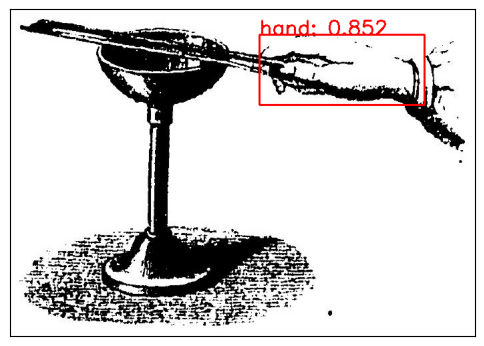

0.85167223


In [97]:
import os, random

CLASS_NAMES = ['__background__', 'hand']
folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/PNGImages1/'
file = random.choice(os.listdir(folder))
pred_score = detect_object((os.path.join(folder,file)),confidence=0.71)
print(pred_score[0])

In [29]:
def get_max_conf():
    model.eval()
    CLASS_NAMES = ['__background__', 'hand']
    folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/PNGImages1/'
    mean_samples = 10
    pred_score_total = 0
    for i in range(mean_samples):
        file = random.choice(os.listdir(folder)) 
        pred_score = detect_object((os.path.join(folder,file)),confidence=0.6)[0]
        pred_score_total = pred_score + pred_score_total
    return (pred_score_total/mean_samples)

# Plot Performance

In [139]:
import os, random
import matplotlib.pyplot as plt
num_epochs = 30
evalutaltion = []
x = range(num_epochs)
y = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    print('evaluate')
    # evaluate on the test dataset
    evalutaltion.append(evaluate(model, data_loader_test, device=device))
    y.append(get_max_conf())
    model.train()
print("That's it!")
plt.plot(x,y)
plt.show()

Epoch: [0]  [ 0/53]  eta: 0:03:25  lr: 0.000000  loss: 0.5265 (0.5265)  loss_classifier: 0.0824 (0.0824)  loss_box_reg: 0.1000 (0.1000)  loss_mask: 0.3107 (0.3107)  loss_objectness: 0.0247 (0.0247)  loss_rpn_box_reg: 0.0087 (0.0087)  time: 3.8826  data: 3.4074  max mem: 4352


KeyboardInterrupt: 

from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#testing-forward-method-optional

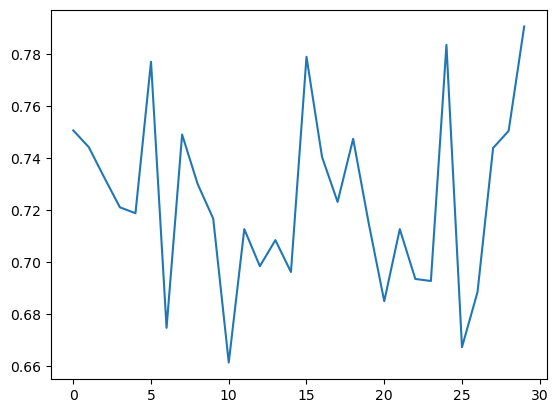

In [123]:
plt.plot(x,y)
plt.show()

# Split data into train/val

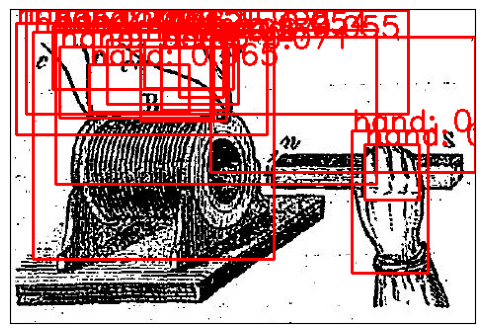

['hand 0.40451944 98 31 231 96\n', 'hand 0.27013725 136 31 219 80\n', 'hand 0.22738469 6 14 260 127\n', 'hand 0.18575686 50 38 206 110\n', 'hand 0.14481065 43 17 226 81\n', 'hand 0.11228796 346 123 423 267\n', 'hand 0.09343998 359 137 414 193\n', 'hand 0.08872259 16 1 403 106\n', 'hand 0.08172078 46 21 371 177\n', 'hand 0.07098938 153 39 221 102\n', 'hand 0.06515712 80 56 181 104\n', 'hand 0.058565114 132 15 219 113\n', 'hand 0.05481744 203 28 471 165\n', 'hand 0.053714 23 23 267 253\n', 'hand 0.053629726 171 24 216 89\n']


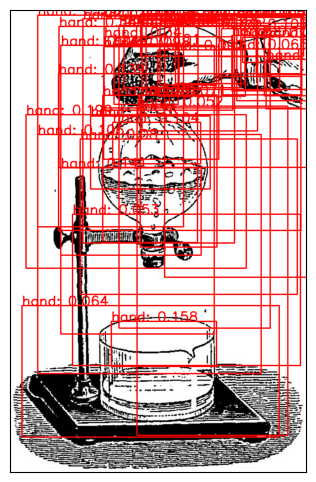

['hand 0.61922884 208 13 644 217\n', 'hand 0.61521107 545 10 658 143\n', 'hand 0.6048911 252 29 511 172\n', 'hand 0.5361352 502 16 658 201\n', 'hand 0.3793902 161 19 497 517\n', 'hand 0.3759497 178 235 443 397\n', 'hand 0.3650691 366 36 520 163\n', 'hand 0.36295083 108 36 658 349\n', 'hand 0.33991092 208 59 493 222\n', 'hand 0.27457476 374 29 658 176\n', 'hand 0.24925391 112 78 452 719\n', 'hand 0.21959357 567 109 658 219\n', 'hand 0.21818303 241 34 576 706\n', 'hand 0.19884023 35 232 523 573\n', 'hand 0.1746388 205 189 415 516\n', 'hand 0.169424 289 8 650 102\n', 'hand 0.15770574 224 691 457 791\n', 'hand 0.14132485 112 350 423 544\n', 'hand 0.13982286 332 25 457 166\n', 'hand 0.13972136 563 59 658 190\n', 'hand 0.13861541 107 141 644 489\n', 'hand 0.11580446 342 11 658 593\n', 'hand 0.10822047 491 56 597 179\n', 'hand 0.10773279 468 41 646 147\n', 'hand 0.1055752 61 276 556 807\n', 'hand 0.104191065 227 249 422 341\n', 'hand 0.101347946 230 75 372 209\n', 'hand 0.09841944 207 81 462 

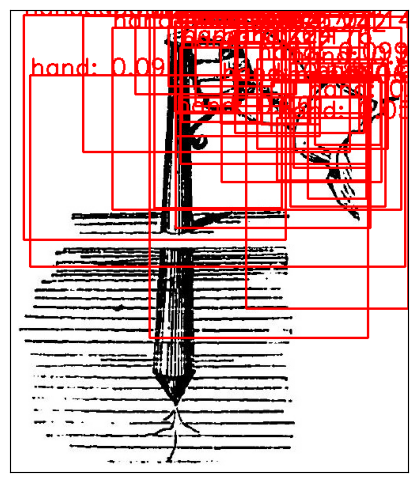

['hand 0.67614657 209 16 391 159\n', 'hand 0.6160777 358 91 455 199\n', 'hand 0.39127964 129 22 494 252\n', 'hand 0.34738532 354 67 474 248\n', 'hand 0.31734562 234 17 353 121\n', 'hand 0.31205782 215 47 452 194\n', 'hand 0.24241613 284 26 441 155\n', 'hand 0.23663516 176 6 452 414\n', 'hand 0.22433464 217 40 318 141\n', 'hand 0.18809646 267 88 469 217\n', 'hand 0.17594337 266 42 379 143\n', 'hand 0.16004264 385 85 468 170\n', 'hand 0.1320183 200 21 333 96\n', 'hand 0.12484566 217 2 453 110\n', 'hand 0.11700025 92 7 429 179\n', 'hand 0.1144247 317 22 391 144\n', 'hand 0.105454154 376 109 450 238\n', 'hand 0.09901486 312 62 477 175\n', 'hand 0.09092517 17 6 348 290\n', 'hand 0.09001692 25 82 499 324\n', 'hand 0.080773585 158 6 361 106\n', 'hand 0.07093898 208 14 287 128\n', 'hand 0.06916574 330 91 447 155\n', 'hand 0.061649296 298 8 503 377\n', 'hand 0.06121121 209 130 455 275\n', 'hand 0.0524916 182 9 343 250\n', 'hand 0.050044436 337 136 452 215\n']


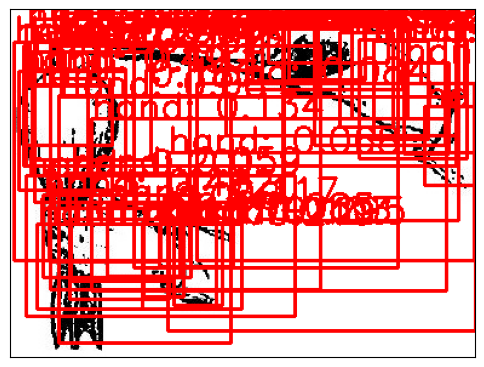

['hand 0.5185429 195 7 324 66\n', 'hand 0.51544493 33 19 79 57\n', 'hand 0.49019992 7 51 95 149\n', 'hand 0.4619832 27 153 149 221\n', 'hand 0.4521478 251 13 359 112\n', 'hand 0.366271 13 14 368 129\n', 'hand 0.36392376 178 2 369 104\n', 'hand 0.29480094 135 176 175 244\n', 'hand 0.25470832 213 5 312 44\n', 'hand 0.24376003 3 27 148 207\n', 'hand 0.21911159 109 177 191 247\n', 'hand 0.20128544 13 137 235 253\n', 'hand 0.18741404 13 63 84 112\n', 'hand 0.18073732 288 25 377 123\n', 'hand 0.1701043 226 3 370 174\n', 'hand 0.14832112 33 30 256 231\n', 'hand 0.13661914 22 177 170 247\n', 'hand 0.1340614 50 173 135 224\n', 'hand 0.1340042 67 90 360 232\n', 'hand 0.13240921 102 11 320 213\n', 'hand 0.12906002 39 24 70 51\n', 'hand 0.12164673 200 16 282 59\n', 'hand 0.11700022 80 160 140 220\n', 'hand 0.102692455 123 176 184 212\n', 'hand 0.10204405 11 50 64 129\n', 'hand 0.08541485 110 173 143 237\n', 'hand 0.0836689 154 61 383 207\n', 'hand 0.08214207 230 7 293 58\n', 'hand 0.081531584 18 3

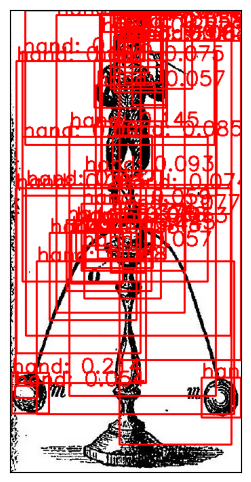

['hand 0.44849405 90 326 166 404\n', 'hand 0.4284676 154 2 203 92\n', 'hand 0.412182 132 5 231 164\n', 'hand 0.37752956 83 310 208 415\n', 'hand 0.22570042 148 3 268 116\n', 'hand 0.22194022 134 32 225 262\n', 'hand 0.21995781 68 7 257 447\n', 'hand 0.21435897 2 536 57 596\n', 'hand 0.2025006 8 263 200 551\n', 'hand 0.14529602 87 172 303 570\n', 'hand 0.14501564 111 323 210 381\n', 'hand 0.13823374 58 329 186 458\n', 'hand 0.1306543 169 6 222 107\n', 'hand 0.11696199 148 25 224 84\n', 'hand 0.1155695 162 9 198 47\n', 'hand 0.114231214 135 0 326 301\n', 'hand 0.1050781 9 75 192 507\n', 'hand 0.09305523 109 237 222 426\n', 'hand 0.089975014 18 187 291 401\n', 'hand 0.088452905 180 43 230 140\n', 'hand 0.087282345 159 43 191 77\n', 'hand 0.08469041 151 185 209 252\n', 'hand 0.08169296 23 258 325 481\n', 'hand 0.08165463 282 543 340 602\n', 'hand 0.07831268 18 62 304 274\n', 'hand 0.07671147 148 294 199 388\n', 'hand 0.074583516 124 74 229 144\n', 'hand 0.07354838 161 263 326 642\n', 'hand

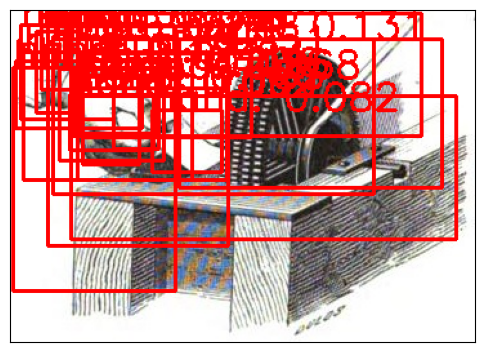

['hand 0.584239 38 46 119 117\n', 'hand 0.3395335 10 33 141 132\n', 'hand 0.24762173 33 23 282 143\n', 'hand 0.20563886 49 51 113 96\n', 'hand 0.1704968 4 40 102 92\n', 'hand 0.15573043 47 3 319 98\n', 'hand 0.15293545 52 61 168 132\n', 'hand 0.1466144 29 13 169 183\n', 'hand 0.1463855 20 17 52 80\n', 'hand 0.13130267 131 23 335 138\n', 'hand 0.12578656 56 52 100 120\n', 'hand 0.123790145 2 45 128 218\n', 'hand 0.09188061 46 66 111 109\n', 'hand 0.08188546 110 78 164 126\n', 'hand 0.07555505 24 13 59 62\n', 'hand 0.068840064 47 67 346 178\n', 'hand 0.06840795 80 53 115 108\n', 'hand 0.056887183 8 12 80 85\n', 'hand 0.050534487 55 34 187 99\n']


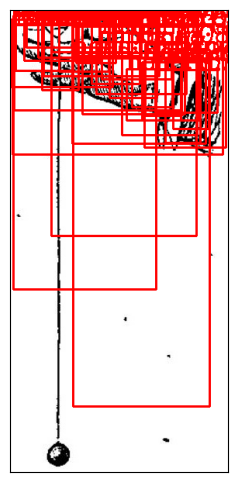

['hand 0.6252947 5 3 221 129\n', 'hand 0.4879365 54 8 157 54\n', 'hand 0.45743322 93 20 225 134\n', 'hand 0.44494814 43 9 192 85\n', 'hand 0.4116258 3 18 274 186\n', 'hand 0.309586 200 64 245 171\n', 'hand 0.23547933 173 63 278 177\n', 'hand 0.23342629 144 21 241 161\n', 'hand 0.17675263 7 19 81 78\n', 'hand 0.16137372 1 12 132 99\n', 'hand 0.15997286 53 6 240 291\n', 'hand 0.14275892 85 5 136 68\n', 'hand 0.13599394 21 12 136 48\n', 'hand 0.13173263 118 29 208 89\n', 'hand 0.10052944 210 55 256 153\n', 'hand 0.09716824 63 7 127 79\n', 'hand 0.089516185 4 7 188 360\n', 'hand 0.08811227 157 30 209 125\n', 'hand 0.08805295 111 41 227 108\n', 'hand 0.08770769 170 67 243 142\n', 'hand 0.0836247 105 9 167 95\n', 'hand 0.08306004 128 21 189 113\n', 'hand 0.08079502 174 44 221 136\n', 'hand 0.07898724 36 2 242 61\n', 'hand 0.07098822 18 17 116 65\n', 'hand 0.07043442 81 55 257 511\n', 'hand 0.06928166 80 62 252 172\n', 'hand 0.06180243 150 76 220 142\n', 'hand 0.059240174 187 77 267 132\n', '

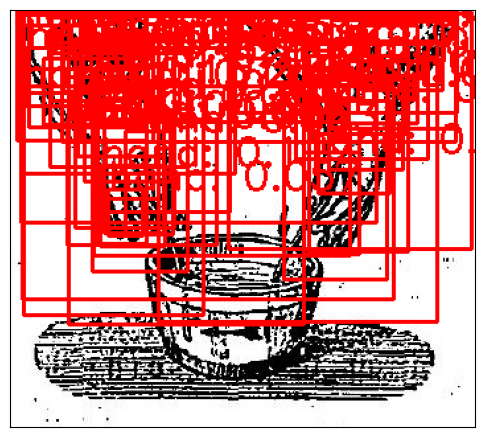

['hand 0.46318856 49 22 124 165\n', 'hand 0.45962703 5 1 103 99\n', 'hand 0.3575974 226 35 301 183\n', 'hand 0.3113833 8 3 277 161\n', 'hand 0.31111032 10 1 146 231\n', 'hand 0.3067485 241 53 297 121\n', 'hand 0.26604033 65 43 112 143\n', 'hand 0.2202131 39 1 337 100\n', 'hand 0.21947935 14 1 61 89\n', 'hand 0.21908483 62 55 134 198\n', 'hand 0.19968611 243 8 337 90\n', 'hand 0.17375143 256 39 308 86\n', 'hand 0.15913978 216 26 316 113\n', 'hand 0.1567728 9 58 290 219\n', 'hand 0.15576746 266 9 327 61\n', 'hand 0.15209438 71 67 116 169\n', 'hand 0.14689614 30 33 134 119\n', 'hand 0.12780029 112 24 323 236\n', 'hand 0.1256671 44 5 222 238\n', 'hand 0.122700326 31 6 93 69\n', 'hand 0.12052337 51 59 116 111\n', 'hand 0.11717157 68 118 117 179\n', 'hand 0.0971634 165 3 349 181\n', 'hand 0.09664004 229 50 300 94\n', 'hand 0.09266773 44 1 102 51\n', 'hand 0.09183847 207 57 285 204\n', 'hand 0.089059494 8 0 170 124\n', 'hand 0.08317323 6 12 74 63\n', 'hand 0.08167243 53 31 108 100\n', 'hand 0

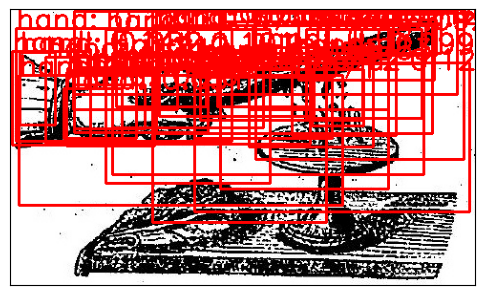

['hand 0.5021321 67 61 207 129\n', 'hand 0.30421692 153 17 442 130\n', 'hand 0.2601214 67 79 141 125\n', 'hand 0.21249148 302 15 444 74\n', 'hand 0.21224032 37 50 314 141\n', 'hand 0.18605335 199 52 369 116\n', 'hand 0.18515137 59 66 151 143\n', 'hand 0.17033224 67 2 468 89\n', 'hand 0.15806669 107 61 265 124\n', 'hand 0.15399444 361 11 446 48\n', 'hand 0.14356008 2 44 84 142\n', 'hand 0.13477458 333 17 435 57\n', 'hand 0.13411178 257 4 475 157\n', 'hand 0.12732626 6 20 232 138\n', 'hand 0.124819696 316 63 370 122\n', 'hand 0.12359929 111 62 205 102\n', 'hand 0.10101158 107 46 433 173\n', 'hand 0.09865126 295 46 404 132\n', 'hand 0.09443104 9 69 348 205\n', 'hand 0.09213556 310 21 431 114\n', 'hand 0.08997923 84 68 132 135\n', 'hand 0.08159107 10 45 47 121\n', 'hand 0.08017852 250 40 396 105\n', 'hand 0.07980635 156 57 318 112\n', 'hand 0.07840228 220 13 396 188\n', 'hand 0.07152626 217 63 314 102\n', 'hand 0.07134552 193 71 337 135\n', 'hand 0.069243565 66 63 175 105\n', 'hand 0.06336

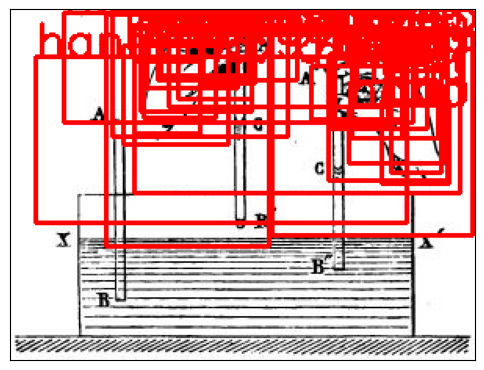

['hand 0.6867577 83 6 154 65\n', 'hand 0.59905666 96 6 152 42\n', 'hand 0.56933147 203 31 279 109\n', 'hand 0.37949756 79 33 121 79\n', 'hand 0.3095016 79 12 287 117\n', 'hand 0.2859152 65 0 177 81\n', 'hand 0.24290277 107 13 154 57\n', 'hand 0.22903533 34 2 257 72\n', 'hand 0.22573587 204 28 266 76\n', 'hand 0.20857053 94 0 183 45\n', 'hand 0.1809344 72 23 139 86\n', 'hand 0.17538504 85 21 131 69\n', 'hand 0.15640652 87 16 145 50\n', 'hand 0.13695219 237 58 280 111\n', 'hand 0.13490261 61 3 165 151\n', 'hand 0.12766881 167 16 295 144\n', 'hand 0.10428811 243 39 275 104\n', 'hand 0.10259577 123 1 156 47\n', 'hand 0.096887104 16 30 253 136\n', 'hand 0.07091664 218 27 250 82\n', 'hand 0.069516554 217 46 273 82\n', 'hand 0.06555822 101 16 244 62\n', 'hand 0.06358027 216 61 276 98\n', 'hand 0.054603927 207 30 241 74\n', 'hand 0.053521544 192 36 253 70\n']


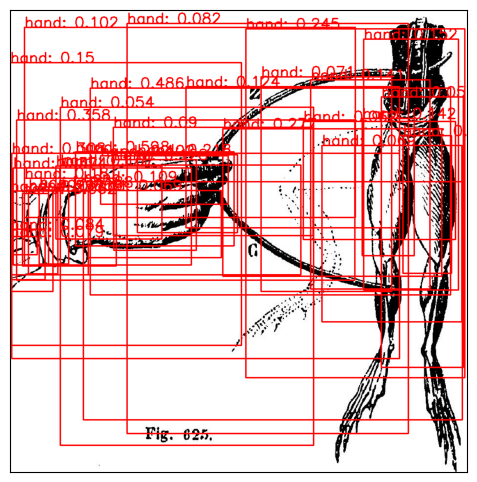

['hand 0.5977098 133 289 456 481\n', 'hand 0.5950469 0 369 159 540\n', 'hand 0.48578605 163 159 897 581\n', 'hand 0.37449306 6 322 369 520\n', 'hand 0.35777953 13 224 702 551\n', 'hand 0.3080481 3 292 793 711\n', 'hand 0.27650496 433 242 879 543\n', 'hand 0.2528007 0 369 87 574\n', 'hand 0.24466182 480 38 926 750\n', 'hand 0.21833642 259 295 463 454\n', 'hand 0.18759902 59 361 119 518\n', 'hand 0.17970473 29 343 216 522\n', 'hand 0.17084567 93 318 309 467\n', 'hand 0.1672237 102 316 592 540\n', 'hand 0.15174256 720 59 913 571\n', 'hand 0.14998049 0 107 471 684\n', 'hand 0.14152905 717 221 823 501\n', 'hand 0.14111514 612 142 855 569\n', 'hand 0.12772295 211 305 379 490\n', 'hand 0.12436562 358 156 793 444\n', 'hand 0.10935671 149 350 921 836\n', 'hand 0.10213263 29 35 703 423\n', 'hand 0.10187234 184 297 444 396\n', 'hand 0.08966872 210 239 617 460\n', 'hand 0.08394522 0 447 71 550\n', 'hand 0.082362466 238 27 811 864\n', 'hand 0.07876739 0 462 55 499\n', 'hand 0.070883945 511 136 777 

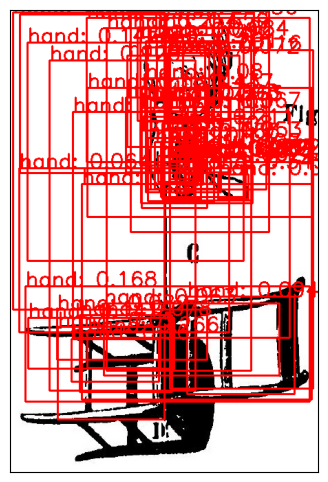

['hand 0.5625218 204 131 266 261\n', 'hand 0.5592903 185 25 317 161\n', 'hand 0.47975427 197 45 306 265\n', 'hand 0.436985 191 114 286 288\n', 'hand 0.34474003 268 230 352 277\n', 'hand 0.32238317 175 1 376 323\n', 'hand 0.3080925 190 175 352 281\n', 'hand 0.26567492 112 468 218 521\n', 'hand 0.25901407 246 211 280 254\n', 'hand 0.25445798 140 26 350 525\n', 'hand 0.25133565 198 54 283 155\n', 'hand 0.21068384 221 165 277 275\n', 'hand 0.1805974 112 113 438 301\n', 'hand 0.1795767 219 214 342 272\n', 'hand 0.1679206 22 402 435 570\n', 'hand 0.16307871 200 186 267 278\n', 'hand 0.14739731 25 47 339 365\n', 'hand 0.14122435 26 448 238 522\n', 'hand 0.12874262 57 73 269 554\n', 'hand 0.11602054 232 58 440 551\n', 'hand 0.114664756 91 148 406 477\n', 'hand 0.10985375 210 192 305 260\n', 'hand 0.102895305 189 142 258 226\n', 'hand 0.09835326 199 129 372 261\n', 'hand 0.097042635 111 11 435 221\n', 'hand 0.09652945 231 201 296 279\n', 'hand 0.09447893 257 417 413 559\n', 'hand 0.0929011 14 6

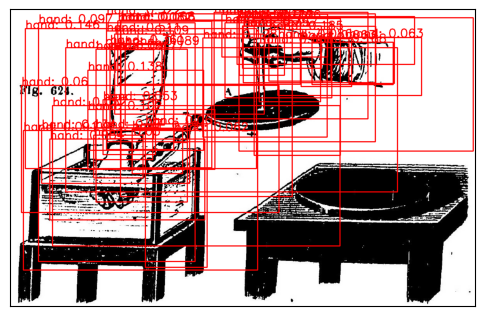

['hand 0.79010344 598 43 801 152\n', 'hand 0.5106871 248 56 421 361\n', 'hand 0.44512144 553 35 828 228\n', 'hand 0.36104465 257 88 391 220\n', 'hand 0.3573336 600 44 941 189\n', 'hand 0.32232884 248 12 940 341\n', 'hand 0.22891203 525 8 921 282\n', 'hand 0.19063948 314 309 444 423\n', 'hand 0.18764968 777 85 986 194\n', 'hand 0.18474962 666 52 826 185\n', 'hand 0.17654596 257 104 369 333\n', 'hand 0.1698999 220 305 367 387\n', 'hand 0.14561158 39 50 634 410\n', 'hand 0.14388843 590 13 706 170\n', 'hand 0.13848314 200 157 498 363\n', 'hand 0.13374253 81 306 462 448\n', 'hand 0.12811804 496 74 816 329\n', 'hand 0.119369805 589 22 1192 365\n', 'hand 0.112003446 143 99 997 470\n', 'hand 0.10940613 269 64 654 270\n', 'hand 0.10572169 284 28 726 482\n', 'hand 0.10199246 200 258 527 412\n', 'hand 0.09693509 73 35 476 649\n', 'hand 0.09097958 34 312 637 671\n', 'hand 0.09049807 221 103 456 496\n', 'hand 0.0886702 296 91 397 298\n', 'hand 0.0855758 689 73 1059 222\n', 'hand 0.08160241 277 30 7

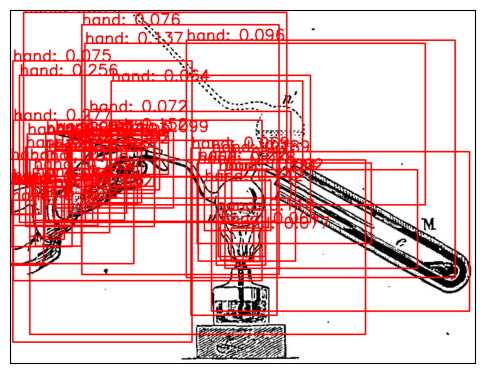

['hand 0.4555758 30 267 280 421\n', 'hand 0.43258718 1 335 120 460\n', 'hand 0.39239544 118 259 281 357\n', 'hand 0.37371194 404 312 495 479\n', 'hand 0.35024008 87 236 317 385\n', 'hand 0.30899012 120 245 307 320\n', 'hand 0.2771011 6 215 489 526\n', 'hand 0.25643578 18 128 583 413\n', 'hand 0.25326326 73 275 247 378\n', 'hand 0.21972445 365 291 554 488\n', 'hand 0.1885197 391 276 892 585\n', 'hand 0.16723938 0 338 65 496\n', 'hand 0.15165815 153 233 255 375\n', 'hand 0.1490943 45 309 222 409\n', 'hand 0.14170675 377 332 506 429\n', 'hand 0.13742419 145 66 806 379\n', 'hand 0.13091914 6 339 60 397\n', 'hand 0.12757105 113 254 430 411\n', 'hand 0.11968037 38 363 100 440\n', 'hand 0.11820844 33 242 279 343\n', 'hand 0.117890164 400 389 496 496\n', 'hand 0.108115405 38 292 690 630\n', 'hand 0.103262305 115 242 226 395\n', 'hand 0.10099167 0 291 240 493\n', 'hand 0.098763056 194 237 290 350\n', 'hand 0.097919196 5 331 170 419\n', 'hand 0.097265944 86 272 193 433\n', 'hand 0.09557856 342 6

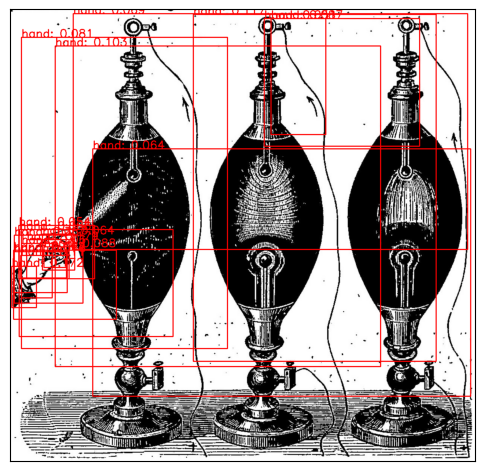

['hand 0.36683133 11 602 194 783\n', 'hand 0.17892154 44 614 157 718\n', 'hand 0.17212304 4 685 70 795\n', 'hand 0.11710857 488 14 1135 938\n', 'hand 0.11022144 28 656 150 716\n', 'hand 0.102533534 120 98 987 952\n', 'hand 0.08768741 90 633 150 688\n', 'hand 0.086750425 695 25 841 334\n', 'hand 0.08575471 24 587 434 872\n', 'hand 0.081464596 30 75 579 904\n', 'hand 0.07569971 10 646 152 755\n', 'hand 0.068889394 168 12 1219 640\n', 'hand 0.06793551 9 642 283 826\n', 'hand 0.06403159 86 599 172 695\n', 'hand 0.063844725 220 372 1227 1031\n', 'hand 0.059778262 30 624 112 769\n', 'hand 0.053623594 23 576 225 718\n', 'hand 0.0505947 677 25 1091 365\n']


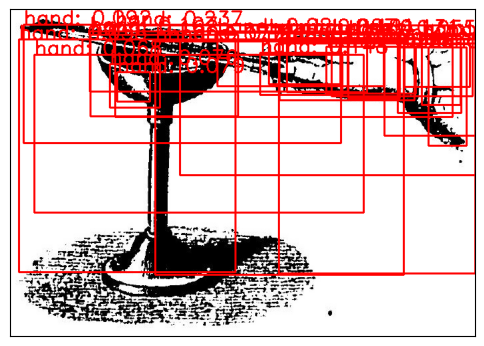

['hand 0.55202216 403 43 605 136\n', 'hand 0.2371719 157 24 662 161\n', 'hand 0.2287429 473 56 607 126\n', 'hand 0.20752706 560 44 696 189\n', 'hand 0.1807728 414 36 534 124\n', 'hand 0.16755226 120 38 341 160\n', 'hand 0.14817177 374 65 497 128\n', 'hand 0.14512125 616 40 674 143\n', 'hand 0.13129371 481 37 692 130\n', 'hand 0.11067758 254 45 696 248\n', 'hand 0.107044406 119 33 505 123\n', 'hand 0.10158444 580 57 675 155\n', 'hand 0.09204254 20 23 495 200\n', 'hand 0.0871603 387 36 494 112\n', 'hand 0.08233022 626 57 683 204\n', 'hand 0.0803411 310 35 559 115\n', 'hand 0.07906904 160 94 209 138\n', 'hand 0.07665673 217 48 589 397\n', 'hand 0.07596004 149 82 224 147\n', 'hand 0.067809924 36 68 529 304\n', 'hand 0.06255959 402 51 696 395\n', 'hand 0.05911663 590 52 688 116\n', 'hand 0.057978712 13 45 337 393\n', 'hand 0.05504913 506 38 583 133\n']


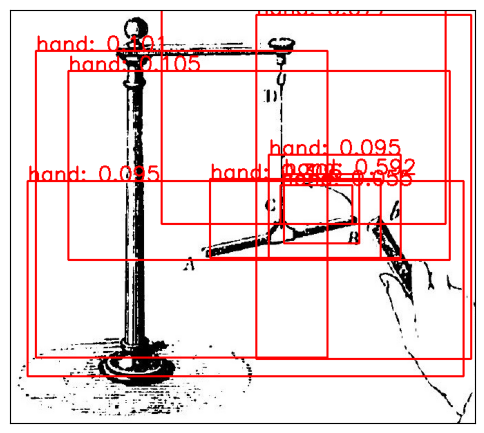

['hand 0.5917539 396 238 505 338\n', 'hand 0.3059181 289 245 536 359\n', 'hand 0.10533317 84 89 636 362\n', 'hand 0.10149217 37 60 459 503\n', 'hand 0.095122784 25 248 656 530\n', 'hand 0.09508423 374 210 565 359\n', 'hand 0.0765581 356 8 667 505\n', 'hand 0.06239425 219 0 630 310\n', 'hand 0.05504124 391 254 495 310\n']


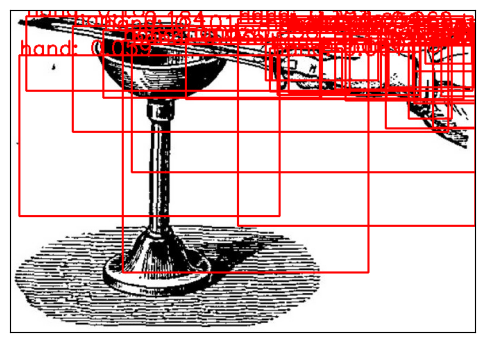

['hand 0.65898967 582 28 670 135\n', 'hand 0.53296393 385 34 590 123\n', 'hand 0.39499986 328 14 653 129\n', 'hand 0.33077765 582 35 668 89\n', 'hand 0.28021356 368 30 530 102\n', 'hand 0.2655417 541 43 670 171\n', 'hand 0.2613702 468 36 580 115\n', 'hand 0.1987767 374 56 478 118\n', 'hand 0.18404438 90 24 631 176\n', 'hand 0.18310054 621 29 670 125\n', 'hand 0.18149115 448 61 591 128\n', 'hand 0.18099777 598 44 665 78\n', 'hand 0.17956935 23 10 666 117\n', 'hand 0.14666732 483 36 670 131\n', 'hand 0.13583815 175 50 670 234\n', 'hand 0.12751068 609 45 670 170\n', 'hand 0.11880448 545 52 668 112\n', 'hand 0.10123968 134 30 446 127\n', 'hand 0.1007614 328 20 670 311\n', 'hand 0.06871889 446 25 534 117\n', 'hand 0.061239127 377 66 449 102\n', 'hand 0.05962283 574 48 636 157\n', 'hand 0.059498087 401 27 489 120\n', 'hand 0.05871178 13 66 388 297\n', 'hand 0.05787052 162 45 516 378\n', 'hand 0.057620984 253 42 542 129\n']


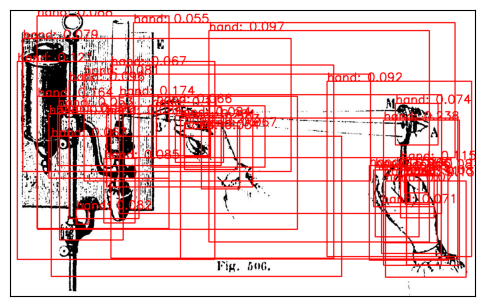

['hand 0.5241065 909 395 1108 634\n', 'hand 0.23809125 945 280 1137 647\n', 'hand 0.20317511 441 287 575 405\n', 'hand 0.2005851 431 275 1133 631\n', 'hand 0.1957914 125 258 286 583\n', 'hand 0.19142455 945 419 1081 590\n', 'hand 0.18537557 920 406 1073 499\n', 'hand 0.17443088 276 216 1092 516\n', 'hand 0.16441639 69 220 727 556\n', 'hand 0.13101955 1003 421 1091 646\n', 'hand 0.120712504 18 132 518 632\n', 'hand 0.11503523 988 380 1073 527\n', 'hand 0.10970517 358 244 645 399\n', 'hand 0.09707171 503 54 1061 588\n', 'hand 0.09594903 149 180 326 529\n', 'hand 0.09197909 802 182 1168 625\n', 'hand 0.087749906 68 17 402 554\n', 'hand 0.08650424 1000 416 1061 493\n', 'hand 0.08497832 237 377 316 540\n', 'hand 0.084367335 418 269 540 387\n', 'hand 0.08413389 244 264 614 449\n', 'hand 0.08167925 167 505 197 543\n', 'hand 0.08101258 187 164 912 434\n', 'hand 0.080964826 998 401 1057 464\n', 'hand 0.07902217 32 74 711 410\n', 'hand 0.07367863 975 238 1083 343\n', 'hand 0.070872605 940 489 10

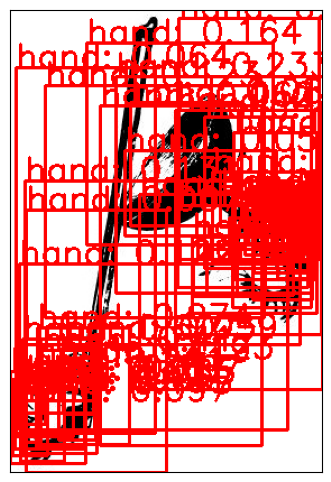

['hand 0.6067319 11 293 77 395\n', 'hand 0.60565746 217 183 268 234\n', 'hand 0.5662805 198 166 268 265\n', 'hand 0.49074152 200 167 242 208\n', 'hand 0.41880187 23 313 66 389\n', 'hand 0.41662425 28 303 74 359\n', 'hand 0.38871112 209 172 255 218\n', 'hand 0.26685923 14 329 75 376\n', 'hand 0.25729546 2 329 33 397\n', 'hand 0.2446519 195 185 259 224\n', 'hand 0.24253593 202 192 252 254\n', 'hand 0.24149945 0 322 67 404\n', 'hand 0.23343766 94 59 268 252\n', 'hand 0.21540412 238 190 271 239\n', 'hand 0.16863647 180 144 266 224\n', 'hand 0.16807449 149 174 265 247\n', 'hand 0.16446945 68 29 234 209\n', 'hand 0.16205898 229 195 262 218\n', 'hand 0.15714902 147 89 277 289\n', 'hand 0.15430401 238 185 255 219\n', 'hand 0.1450442 6 341 31 369\n', 'hand 0.14029896 175 213 247 254\n', 'hand 0.1368238 211 170 237 196\n', 'hand 0.13084851 13 152 258 298\n', 'hand 0.1265732 224 187 257 210\n', 'hand 0.12287804 31 67 226 274\n', 'hand 0.122594185 43 310 76 383\n', 'hand 0.12223109 8 226 247 374\n

In [125]:
import os, random
import shutil
gts = 'metrics/gts'
det = 'metrics/det'
img = 'metrics/img'
CLASS_NAMES = ['__background__', 'hand']
folder = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/PNGImages1/'
for image in dataset_test.indices:
    f = open(os.path.join(det,sorted(os.listdir(folder))[image][:-4]+".txt"), "w")
    pred_score, boxes = detect_object((os.path.join(folder,sorted(os.listdir(folder))[image])),confidence=0)
    text = []
    for i in range(len(boxes)):
        text.append('hand '+ str(pred_score[i])+ ' '+ str(int(boxes[i][0][0]))+ ' '+str(int(boxes[i][0][1]))+ ' '+ str(int(boxes[i][1][0]))+ ' '+ str(int(boxes[i][1][1]))+'\n')
    print(text)
    f.writelines(text)
    f.close
    #print(boxes)
    #print(pred_score[0])
for i in range(len(dataset_test.indices)):
    f = open(os.path.join(gts,sorted(os.listdir(folder))[i][:-4]+".txt"), "w")
    image, target = dataset_test[i]
    text = []
    for element in target['boxes']:
        text.append('hand ' + str(int(element[0])) +' ' + str(int(element[1])) +' '+str(int(element[2])) +' '+str(int(element[3]))+'\n')
    f.writelines(text)
    f.close
for i in range(len(dataset_test.indices)):
    shutil.copyfile((os.path.join(folder,sorted(os.listdir(folder))[i])), (os.path.join(img,sorted(os.listdir(folder))[i])))

In [122]:
for i in range(len(dataset_test.indices)):
    #f = open(os.path.join(gts,sorted(os.listdir(folder))[i][:-4]+".txt"), "w")
    image, target = dataset_test[i]
    text = []
    for element in target['boxes']:
        text.append('hand ' + str(int(element[0])) +' ' + str(int(element[1])) +' '+str(int(element[2])) +' '+str(int(element[3])))
    print(text)
    #f.writelines(text)
    #f.close

['hand 344 131 423 255', 'hand 352 158 416 232']
['hand 229 22 527 169', 'hand 239 31 496 127']
['hand 192 7 396 153', 'hand 199 23 319 144']
['hand 24 3 362 230', 'hand 24 23 352 226', 'hand 26 146 140 225']
['hand 208 62 225 83']
['hand 33 46 122 129']
['hand 4 4 218 141', 'hand 22 23 208 79']
['hand 56 40 295 189', 'hand 56 43 271 178', 'hand 58 47 120 168']
['hand 54 58 231 141', 'hand 118 63 208 128']
['hand 74 0 282 113', 'hand 76 1 240 86', 'hand 78 2 156 84']
['hand 108 285 455 492', 'hand 111 320 452 480']
['hand 200 146 282 279', 'hand 207 156 264 272']
['hand 208 43 798 516', 'hand 208 47 784 516', 'hand 210 346 330 514']
['hand 85 243 307 417', 'hand 175 259 264 368']
['hand 30 579 175 743', 'hand 31 615 96 711']
['hand 368 36 617 141', 'hand 383 39 608 128']
['hand 531 355 672 597', 'hand 551 399 660 584']
['hand 346 23 588 135']
['hand 411 220 1090 615', 'hand 412 223 1080 592', 'hand 413 224 581 439']
['hand 16 170 263 391', 'hand 22 191 248 391', 'hand 23 306 76 389']


In [65]:
for i in dataset.indices:
    print(os.listdir(EVERYTHING_MASKS)[i])

ganot_ed13-231_4_mask.jpg
ganot_ed17-683_2_mask.jpg
ganot_ed13-671_1_mask.jpg
desains_t1s3-519_3_mask.jpg
ganot_ed13-315_1_mask.jpg
desains_t1s1-163_2_mask.jpg
ganot_ed13-028_1_mask.jpg
ganot_ed17-238_1_mask.jpg
ganot_ed17-829_1_mask.jpg
daguin_t3-0332_1_mask.jpg
ganot_ed17-034_2_mask.jpg
desains_t1s3-517_1_mask.jpg
ganot_ed13-635_2_mask.jpg
ganot_ed17-684_7_mask.jpg
ganot_ed13-316_1_mask.jpg
desains_t1s3-169_8_mask.jpg
ganot_ed17-416_2_mask.jpg
ganot_ed13-231_2_mask.jpg
ganot_ed17-119_3_mask.jpg
ganot_ed13-834_1_mask.jpg
ganot_ed13-237_1_mask.jpg
daguin_t2-388_1_mask.jpg
ganot_ed17-637_2_mask.jpg
jamin_ed3t3-0021_2_mask.jpg
daguin_t1-0088_2_mask.jpg
daguin_t1-0127_1_mask.jpg
deguin_ed7-315_1_mask.jpg
ganot_ed17-573_1_mask.jpg
ganot_ed13-662_1_mask.jpg
ganot_ed17-415_1_mask.jpg
daguin_t2-516_1_mask.jpg
daguin_t2-244_1_mask.jpg
deguin_ed7-096_2_mask.jpg
ganot_ed13-735_1_mask.jpg
ganot_ed13-798_1_mask.jpg
ganot_ed13-587_3_mask.jpg
ganot_ed13-031_2_mask.jpg
ganot_ed13-587_2_mask.jpg
ganot

In [98]:
import random
import os
import shutil

TRAIN = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/train'
TRAIN_MASKS = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/train_mask'
VAL = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/val'
VAL_MAKS = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/val_mask'
EVERYTHING = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/everything'
EVERYTHING_MASKS = '/scratch/ndillenb/notebooks/Hand-Segmentation/Maks_to_coco/dataset/everything_masks'
for i in dataset.indices: 
    shutil.copyfile(os.path.join(EVERYTHING,sorted(os.listdir(EVERYTHING))[i]), os.path.join(TRAIN,sorted(os.listdir(EVERYTHING))[i]))
    shutil.copyfile(os.path.join(EVERYTHING_MASKS,sorted(os.listdir(EVERYTHING_MASKS))[i]), os.path.join(TRAIN_MASKS,sorted(os.listdir(EVERYTHING_MASKS))[i]))
for i in dataset_test.indices: 
    shutil.copyfile(os.path.join(EVERYTHING,sorted(os.listdir(EVERYTHING))[i]), os.path.join(VAL,sorted(os.listdir(EVERYTHING))[i]))
    shutil.copyfile(os.path.join(EVERYTHING_MASKS,sorted(os.listdir(EVERYTHING_MASKS))[i]), os.path.join(VAL_MAKS,sorted(os.listdir(EVERYTHING_MASKS))[i]))